In [1]:
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles # requires pip install matplotlib_venn
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
# import lightgbm as lgb

from utils import featurize_date_col

sns.set()
%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
# user inputs:
LIMIT = 200000

In [74]:
train = pd.read_csv('data/train.csv', parse_dates=['activation_date'], infer_datetime_format=True, nrows=LIMIT)
train_active = pd.read_csv('data/train_active.csv', parse_dates=['activation_date'], infer_datetime_format=True, nrows=LIMIT)
test = pd.read_csv('data/test.csv', parse_dates=['activation_date'], infer_datetime_format=True, nrows=LIMIT)
test_active = pd.read_csv('data/test_active.csv', parse_dates=['activation_date'], infer_datetime_format=True, nrows=LIMIT)

In [101]:
all_samples = pd.concat([
    train,
    train_active,
    test,
    test_active
]).reset_index(drop=True)
all_samples.drop_duplicates(['item_id'], inplace=True) # here we assume each item was published only once?

# del train_active
# del test_active
gc.collect()

518

In [76]:
train_periods = pd.read_csv('data/periods_train.csv', parse_dates=['date_from', 'date_to', 'activation_date'], infer_datetime_format=True, nrows=LIMIT)
test_periods = pd.read_csv('data/periods_test.csv', parse_dates=['date_from', 'date_to', 'activation_date'], infer_datetime_format=True, nrows=LIMIT)

In [77]:
all_periods = pd.concat([
    train_periods,
    test_periods
])

del train_periods
del test_periods
gc.collect()

7

In [78]:
all_periods.columns

Index(['item_id', 'activation_date', 'date_from', 'date_to'], dtype='object')

In [103]:
all_samples = all_samples.drop(['deal_probability', 'image', 'image_top_1', 'param_2', 'param_3'], axis=1)

In [140]:
# all_samples.loc[all_samples['description'].isna(), 'description'] = 'unknown'
# all_samples.loc[all_samples['param_1'].isna(), 'param_1'] = 'unknown'
# all_samples.loc[all_samples['title'].isna(), 'title'] = 'unknown'
all_samples['description'] = all_samples['description'].fillna('na')
all_samples['param_1'] = all_samples['param_1'].fillna('na')
all_samples['title'] = all_samples['title'].fillna('na')

In [111]:
all_samples = all_samples[~all_samples['category_name'].isna()]

In [113]:
mean_cat_price = all_samples[['price', 'category_name']].groupby('category_name')['price'].mean()
std_cat_price = all_samples[['price', 'category_name']].groupby('category_name')['price'].std()

In [114]:
all_samples['price'] = all_samples['price'].fillna(0.0) # fillna with the normalized mean price of the category (i.e. 0.0)

In [123]:
all_samples['norm_price'] = all_samples['price']
for cat in all_samples['category_name'].unique():
    indexes = all_samples['category_name']==cat
    all_samples.loc[indexes, 'norm_price'] -= mean_cat_price[cat]
    all_samples.loc[indexes, 'norm_price'] /= std_cat_price[cat]

In [131]:
all_samples.loc[all_samples['item_seq_number'].isna(), 'item_seq_number'] = all_samples['item_seq_number'].median()

In [135]:
all_samples['user_type'] = all_samples['user_type'].fillna('Private') # most frquent user type (mode)

In [169]:
all_samples = all_samples.loc[~all_samples['activation_date'].isna(), :]

In [170]:
all_samples.isna().sum()/len(all_samples)* 100

activation_date         0.0
category_name           0.0
city                    0.0
description             0.0
item_id                 0.0
item_seq_number         0.0
param_1                 0.0
parent_category_name    0.0
price                   0.0
region                  0.0
title                   0.0
user_id                 0.0
user_type               0.0
norm_price              0.0
dtype: float64

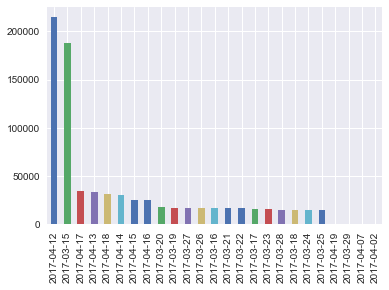

In [159]:
pd.value_counts(all_samples['activation_date'].dropna().astype(str)).plot(kind='bar')